# 使用说明书
### 此代码实现的功能如下：
+ 读取data文件夹下所有的文件
+ 数据预处理：将Cal文件内数据读取并进行处理
+ 计算响应电阻、响应大小、区分度、响应稳定性、恢复程度、基线偏差
+ 从响应电阻、响应大小、区分度、响应稳定性、恢复程度、基线偏差对数据进行分组
+ 绘制响应电阻、响应大小、区分度 曲线图像
+ 筛选出满足6参数或是7参数的部件
+ 绘制不良品参数柱状图
+ 生成数据分析报告

---

### 注意事项：
1. ~~生成的报告文件批次目前仍然要手动填写~~
2. 测试的文件一定要先进行预处理，包括文件内容要包含0 200 100 80 50 51 53 0 或 0 80 50 51 53 0 ,否则要在ETH文件定位并抓取缺失点
3.  如因环境原因导致基线偏移需手动修改两个基线（在ETH文件抓取，第一基线和第二基线相差120行）
4. 目前仍未知空载位置是否会对分析结果造成影响（如良品率，测试总数）
5. 将cal文件放入data文件夹， ETH文件放入ETH_data文件夹
6. 一次只能处理同一批次的 ***测试文件*** 



```mermaid
操作流程
    [1]获取同一批次数据文件 
    --> [2]查看数据情况
    --> [3]有无测试点丢失点 
      --> [4_1]有 --> [5]抓取数据，在Cal文件里补充 --> [6]
      --> [4_2]无 --> [6]
    [6]将同一批次的Cal文件放到 data文件夹， 总数据文件（如ETH.txt）放到batch文件夹 
    --> [7]运行代码
    --> [8]在report文件夹查看报告
```


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objs as go
import numpy as np
import os
import math
import seaborn as sns
import re
from decimal import Decimal

读取文件内所有文件

In [2]:
def get_filepaths(dir):
    filepaths = []
    for filename in os.listdir(dir):
        filepath = os.path.join(dir, filename)
        if os.path.isfile(filepath):
            filepaths.append(filepath)
    return filepaths
 
filepaths = get_filepaths("data")
for i,j in enumerate(filepaths):
    filepaths[i]=j[5:]

if pd.read_csv("data/"+filepaths[0],sep=r'\s+',names=[str(i) for i in range(2500)]).columns.__len__()==7:
    #data_total = pd.DataFrame(columns=["0","80","50","51","53","20","0_2","no"])
    data_total = pd.DataFrame(columns=[i for i in range(6)])
    for j,i in enumerate(filepaths):
        data = pd.read_csv("data/"+i,sep=r'\s+',names=[str(i) for i in range(2500)])
        data_total=data_total.transpose().dropna(how="all",axis=0)
        data = data_total[data.sum(axis=1) != 0][1:]
        data["no"] = data.index.values.astype(int)
        data["batch"]=filepaths[j][15:-4]
        #data_total.columns = columns=["0","80","50","51","53","20","0_2","no"]
        data_total= pd.concat([data_total,data])
else:
    #data_total = pd.DataFrame(columns=["0","200","100","80","50","51","53","0_2","no"])
    data_total = pd.DataFrame(columns=[i for i in range(7)])
    for j,i in enumerate(filepaths):
        data = pd.read_csv("data/"+i,sep=r'\s+',names=[str(i) for i in range(2500)])
        data=data.transpose().dropna(how="all",axis=0)
        data = data[data.sum(axis=1) != 0][1:]
        data["no"] = data.index.values.astype(int)
        data["batch"]=int(j)
        #data_total.columns = columns=["0","200","100","80","50","51","53","0_2","no"]
        data_total= pd.concat([data_total,data])

C:\Users\Administrator\AppData\Local\Temp\ipykernel_8008\2528481275.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_total= pd.concat([data_total,data])


In [3]:
batch_name = filepaths[0][15:]
pattern = r'\d+'
numbers = re.findall(pattern, batch_name)
batch_name = filepaths[0][15:]
batch_name_1=""
batch_name_1+=batch_name[:batch_name.find(numbers[0])+numbers[0].__len__()]
batch_name=batch_name[batch_name.find(numbers[0])+numbers[0].__len__():]
batch_name_1+=batch_name[:batch_name.find(numbers[1])+numbers[1].__len__()]
batch_name_2=batch_name_1
batch_name=batch_name[batch_name.find(numbers[1])+numbers[1].__len__():]
batch_name=batch_name[batch_name.find(numbers[2])+numbers[2].__len__():]
total_num = sum([int(re.findall(pattern, i[15:])[3]) for i in filepaths])
batch_name_1+="_"+str(total_num)+batch_name[batch_name.find(numbers[3])+numbers[3].__len__():-4]
batch_name=batch_name_1

读取区间文件和计算指标


In [4]:
scale = pd.read_csv("scale_file.csv").T
scale.index=["response_resistance_x","response_size_x","discrimination_x","response_stability_x","restoration_x","baseline_deviation_x","high_discrimination_x"
                     ]
response_resistance_x=list(scale[scale.index=="response_resistance_x"].T["response_resistance_x"])
response_size_x=list(scale[scale.index=="response_size_x"].T["response_size_x"])
discrimination_x=list(scale[scale.index=="discrimination_x"].T["discrimination_x"])
response_stability_x=list(scale[scale.index=="response_stability_x"].T["response_stability_x"])
restoration_x=list(scale[scale.index=="restoration_x"].T["restoration_x"])
baseline_deviation_x=list(scale[scale.index=="baseline_deviation_x"].T["baseline_deviation_x"])
high_discrimination_x=list(scale[scale.index=="high_discrimination_x"].T["high_discrimination_x"])

response_resistance_x=[x for x in response_resistance_x if not math.isnan(x)]
response_size_x=[x for x in response_size_x if not math.isnan(x)]
discrimination_x=[x for x in discrimination_x if not math.isnan(x)]
response_stability_x=[x for x in response_stability_x if not math.isnan(x)]
restoration_x=[x for x in restoration_x if not math.isnan(x)]
baseline_deviation_x=[x for x in baseline_deviation_x if not math.isnan(x)]
high_discrimination_x=[x for x in high_discrimination_x if not math.isnan(x)]

In [5]:
if data_total.columns.__len__()==10:
    # response_resistance = data_total["50"]
    # response_size = data_total["0"]/data_total["50"]
    # discrimination = data_total["50"]/data_total["80"]
    # response_stability=data_total["51"]/data_total["50"]
    # restoration=data_total["53"]/data_total["0"]
    # baseline_deviation=(data_total["0"]-data_total["0_2"])/data_total["0"]
    # high_discrimination=data_total["100"]/data_total["200"]
    response_resistance = data_total[4]
    response_size = data_total[0]/data_total[4]
    discrimination = data_total[4]/data_total[3]
    response_stability=data_total[5]/data_total[4]
    restoration=data_total[6]/data_total[0]
    baseline_deviation=(data_total[0]-data_total[7])/data_total[0]
    high_discrimination=data_total[2]/data_total[1]
    
if data_total.columns.__len__()==9:
    # response_resistance = data_total["50"]
    # response_size = data_total["0"]/data_total["50"]
    # discrimination = data_total["50"]/data_total["80"]
    # response_stability=data_total["51"]/data_total["50"]
    # restoration=data_total["53"]/data_total["0"]
    # baseline_deviation=(data_total["0"]-data_total["0_2"])/data_total["0"]
    response_resistance = data_total[2]
    response_size = data_total[0]/data_total[2]
    discrimination = data_total[2]/data_total[1]
    response_stability = data_total[3]/data_total[2]
    restoration = data_total[4]/data_total[0]
    baseline_deviation=(data_total[0]-data_total[6])/data_total[0]

绘图

In [6]:
y_1=[0]+list(pd.cut(response_resistance,bins=response_resistance_x).value_counts(sort=False,normalize=True)[:11].values)
y_2=[0]+list(pd.cut(response_size,bins=response_size_x).value_counts(sort=False,normalize=True)[:16].values)
y_3=[0]+list(pd.cut(discrimination,bins=discrimination_x).value_counts(sort=False,normalize=True)[5:25].values)
y_4=[0]+list(pd.cut(response_stability,bins=response_stability_x).value_counts(sort=False,normalize=True)[10:30].values)
y_5=[0]+list(pd.cut(restoration,bins=restoration_x).value_counts(sort=False,normalize=True)[17:-1].values)
y_6=[0]+list(pd.cut(baseline_deviation,bins=baseline_deviation_x).value_counts(sort=False,normalize=True)[15:-1].values)

x_1=response_resistance_x[:12]
x_2=response_size_x[:17]
x_3=discrimination_x[5:26]
x_4=response_stability_x[10:31]
x_5=restoration_x[17:-1]
x_6=baseline_deviation_x[15:-1]
if data_total.columns.__len__()==8:
    x_7=high_discrimination_x[5:27]
    y_7=[0]+list(pd.cut(high_discrimination,bins=high_discrimination_x).value_counts(sort=False,normalize=True)[5:26].values)


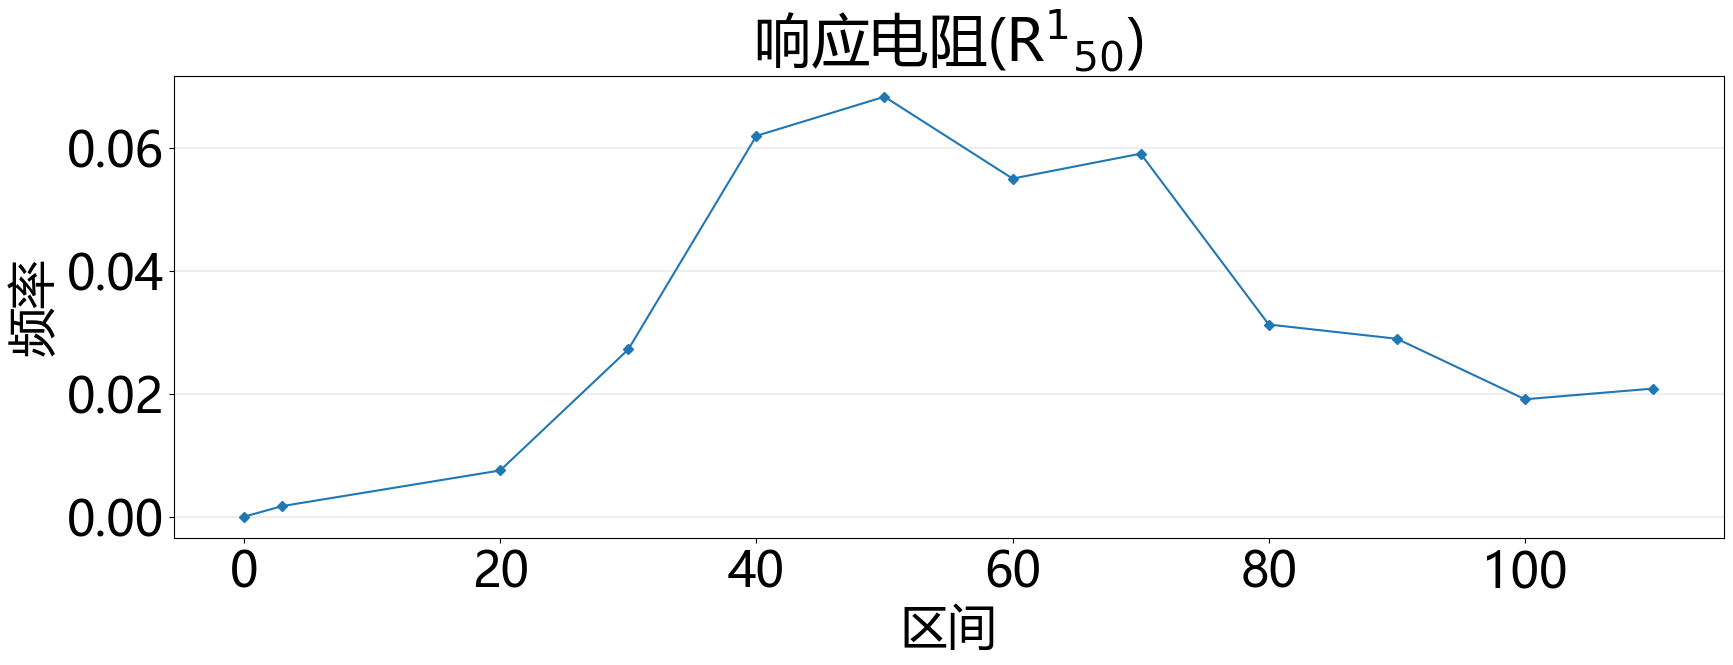

409600: 762


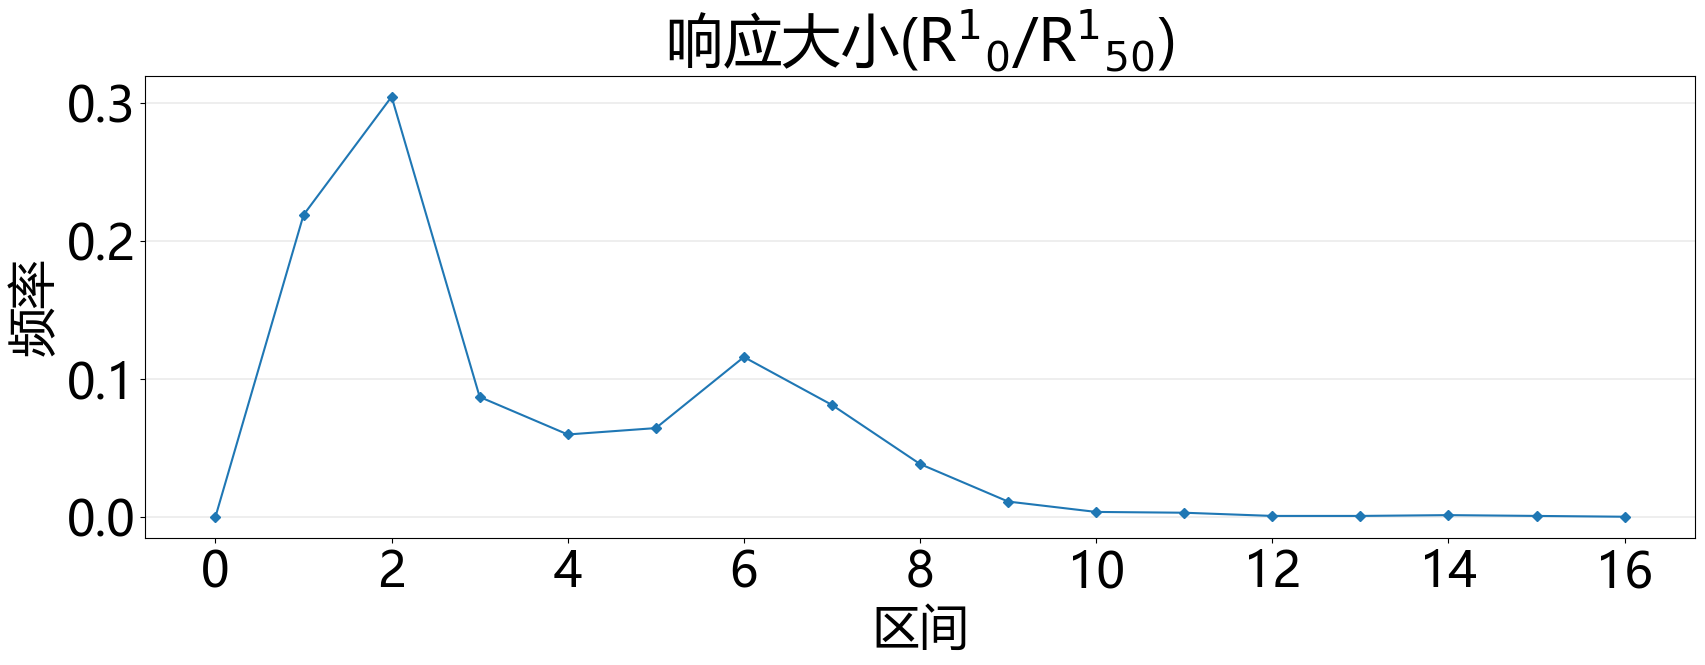

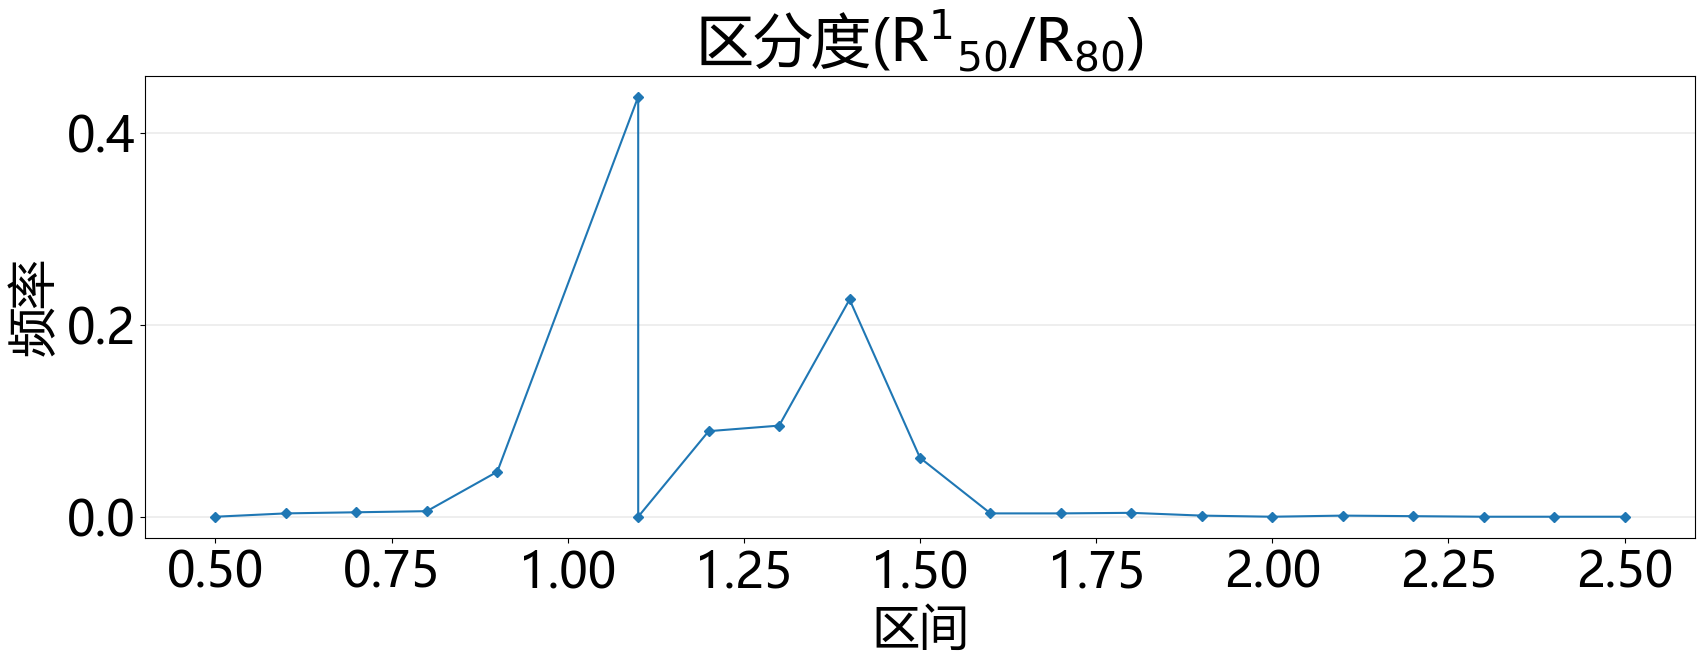

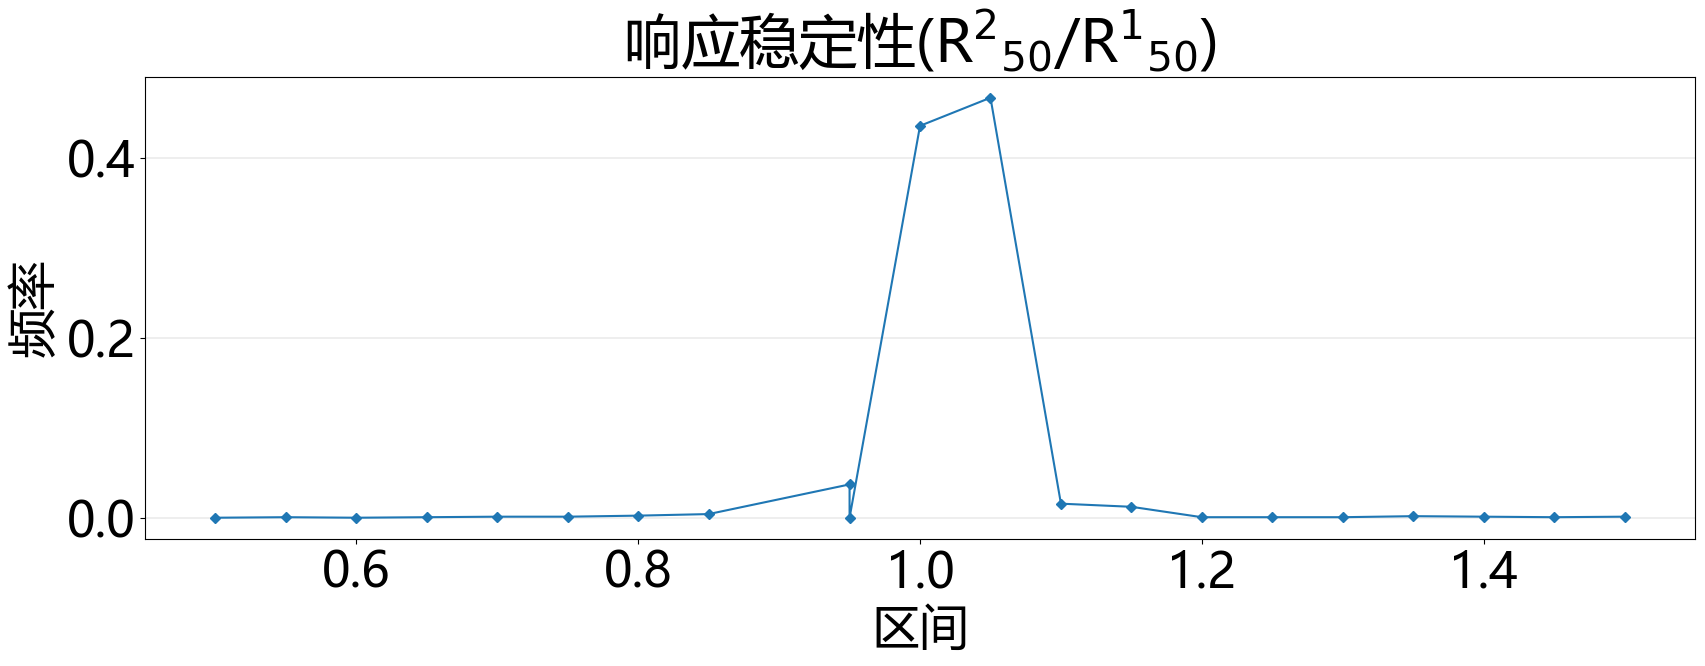

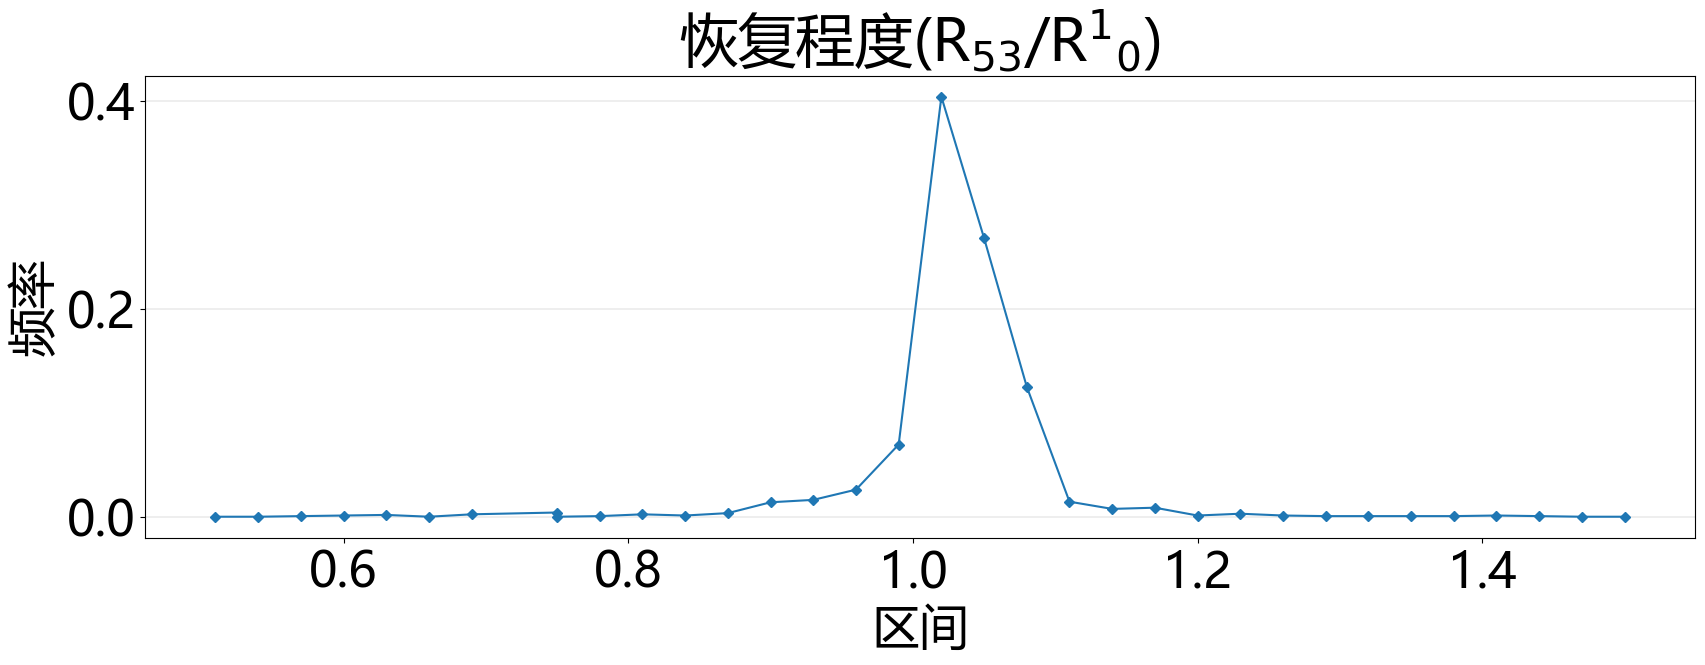

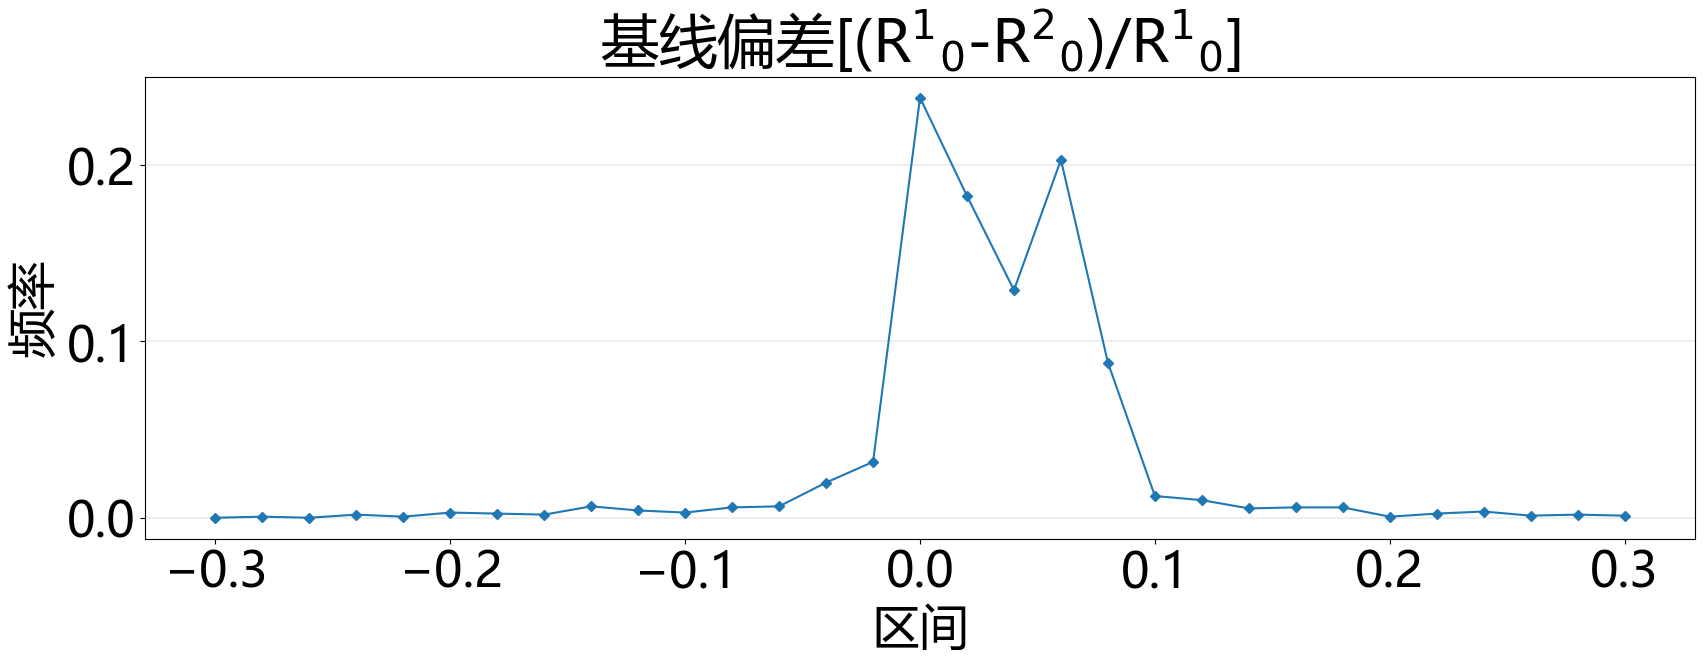

In [7]:
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei'] 
plt.rcParams["font.size"] =35
plt.figure(figsize=(20, 6))
plt.title("响应电阻(R$^{1}$$_{50}$)")
plt.xlabel("区间")
plt.ylabel("频率")
plt.grid( axis='y', linewidth=0.3)
plt.plot(x_1, y_1 ,marker='D', markersize=5)
plt.savefig('响应电阻.png')
plt.show()

print("409600:",pd.cut(response_resistance,bins=response_resistance_x).value_counts(sort=False).values[-1])

plt.figure(figsize=(20, 6))
plt.title("响应大小(R$^{1}$$_{0}$/R$^{1}$$_{50}$)")
plt.xlabel("区间")
plt.ylabel("频率")
plt.grid( axis='y', linewidth=0.3)
plt.plot(x_2, y_2, marker='D', markersize=5)
plt.savefig('响应大小.png')
plt.show()

plt.figure(figsize=(20, 6))
plt.title("区分度(R$^{1}$$_{50}$/R$_{80}$)")
plt.xlabel("区间")
plt.ylabel("频率")
plt.grid( axis='y', linewidth=0.3)
plt.plot(x_3, y_3, marker='D', markersize=5)
plt.savefig('区分度.png')
plt.show()

plt.figure(figsize=(20, 6))
plt.title("响应稳定性(R$^{2}$$_{50}$/R$^{1}$$_{50}$)")
plt.xlabel("区间")
plt.ylabel("频率")
plt.grid( axis='y', linewidth=0.3)
plt.plot(x_4, y_4, marker='D', markersize=5)
plt.savefig('响应稳定性.png')
plt.show()

plt.figure(figsize=(20, 6))
plt.title("恢复程度(R$_{53}$/R$^{1}$$_{0}$)")
plt.xlabel("区间")
plt.ylabel("频率")
plt.grid( axis='y', linewidth=0.3)
plt.plot(x_5, y_5, marker='D', markersize=5)
plt.savefig('恢复程度.png')
plt.show()

plt.figure(figsize=(20, 6))
plt.title("基线偏差[(R$^{1}$$_{0}$-R$^{2}$$_{0}$)/R$^{1}$$_{0}$]")
plt.xlabel("区间")
plt.ylabel("频率")
plt.grid( axis='y', linewidth=0.3)
plt.plot(x_6, y_6, marker='D', markersize=5)
plt.savefig('基线偏差.png')
plt.show()

if data_total.columns.__len__()==8:
    plt.title("大浓度区分度值(R$_{200}$/R$_{100}$)")
    plt.xlabel("区间")
    plt.ylabel("频率")
    plt.grid( axis='y', linewidth=0.3)
    plt.plot(x_7, y_7, marker='D', markersize=5)
    plt.savefig('大浓度区分度值.png')
    plt.show()

plt.close()


筛选

In [8]:
no_=data_total.index.values.astype(int)
if data_total.columns.__len__()==9:
    data_processed = pd.concat(
        [pd.Series(no_,index=response_resistance.index),
        response_resistance,response_size,discrimination,response_stability,restoration,baseline_deviation
        ,data_total["batch"]],axis=1)
    columns=["序号","响应电阻",
    "响应大小",
    "区分度",
    "响应稳定性",
    "恢复程度",
    "基线偏差",
    "部分"
    ]
if data_total.columns.__len__()==10:
    data_processed = pd.concat(
        [pd.Series(no_,index=response_resistance.index),
        response_resistance,response_size,discrimination,response_stability,restoration,baseline_deviation,high_discrimination
        ,data_total["batch"]],axis=1)
    columns=["序号","响应电阻",
    "响应大小",
    "区分度",
    "响应稳定性",
    "恢复程度",
    "基线偏差",
    "大浓度区分度",
    "部分"
    ]
data_processed.columns=columns


In [9]:
step_1=pd.merge(
    data_processed[data_processed["响应电阻"]>=3] , data_processed[data_processed["响应电阻"]<=30],how="inner"
    )

step_2=pd.merge(
    step_1[step_1["响应大小"]>=2] , step_1[step_1["响应大小"]<=15],how="inner"
    )


step_3=pd.merge(
    step_2[step_2["区分度"]>=1.1] , step_2[step_2["区分度"]<=1.5],how="inner"
    )


step_4=pd.merge(
    step_3[step_3["响应稳定性"]>=0.95] , step_3[step_3["响应稳定性"]<=1.05],how="inner"
    )


step_5=step_4[step_4["恢复程度"]>0.75]

step_6=pd.merge(
    step_5[step_5["基线偏差"]>=-0.2] , step_5[step_5["基线偏差"]<=0.1],how="inner"
    )


if data_total.columns.__len__()==10:
    step_7=step_6[step_6["大浓度区分度"]>1.3]

In [10]:
step_6_=step_6.copy()
step_6_.index=step_6["序号"]
step_6_.index.name=''
merged = pd.concat([data_processed,step_6_])
merged.drop_duplicates(keep=False,inplace=True)

In [11]:
if data_total.columns.__len__()==10:
    step_7_=step_7.copy()
    step_7_.index=step_7["序号"]
    step_7_.index.name=''
    merged = pd.concat([data_processed,step_7_])
    merged.drop_duplicates(keep=False,inplace=True)

In [12]:
defective_products_1 = []
defective_products_1.append(pd.concat(
    [merged[merged["响应电阻"]<3] , merged[merged["响应电阻"]>30]]
    ).__len__()/merged.__len__())
defective_products_1.append(pd.concat(
    [merged[merged["响应大小"]<2] , merged[merged["响应大小"]>15]]
    ).__len__()/merged.__len__())
defective_products_1.append(pd.concat(
    [merged[merged["区分度"]<1.1] , merged[merged["区分度"]>1.5]]
    ).__len__()/merged.__len__())
defective_products_1.append(pd.concat(
    [merged[merged["响应稳定性"]<0.95] , merged[merged["响应稳定性"]>1.05]]
    ).__len__()/merged.__len__())
defective_products_1.append(merged[merged["恢复程度"]<=0.75].__len__()/merged.__len__())
defective_products_1.append(pd.concat(
    [merged[merged["基线偏差"]<-0.2] , merged[merged["基线偏差"]>0.1]]
    ).__len__()/merged.__len__())
if data_total.columns.__len__()==10:
    defective_products_1.append(merged[merged["大浓度区分度"]<=1.3].__len__()/merged.__len__())

In [13]:
defective_products_2 = []
defective_products_2.append(pd.concat(
    [merged[merged["响应电阻"]<3] , merged[merged["响应电阻"]>30]]
    ).__len__())
defective_products_2.append(pd.concat(
    [merged[merged["响应大小"]<2] , merged[merged["响应大小"]>15]]
    ).__len__())
defective_products_2.append(pd.concat(
    [merged[merged["区分度"]<1.1] , merged[merged["区分度"]>1.5]]
    ).__len__())
defective_products_2.append(pd.concat(
    [merged[merged["响应稳定性"]<0.95] , merged[merged["响应稳定性"]>1.05]]
    ).__len__())
defective_products_2.append(merged[merged["恢复程度"]<=0.75].__len__())
defective_products_2.append(pd.concat(
    [merged[merged["基线偏差"]<-0.2] , merged[merged["基线偏差"]>0.1]]
    ).__len__())
if data_total.columns.__len__()==10:
    defective_products_2.append(merged[merged["大浓度区分度"]<=1.3].__len__())

In [14]:
defective_products_x=["不符合响应电阻","不符合响应大小","不符合区分度","不符合响应稳定性","不符合恢复程度","不符基线偏差"]
if data.columns.__len__()==10:
    defective_products_x=["不符合响应电阻","不符合响应大小","不符合区分度","不符合响应稳定性","不符合恢复程度","不符基线偏差","不符合大浓度区分度"]
x_=[i for i in range(defective_products_1.__len__())]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


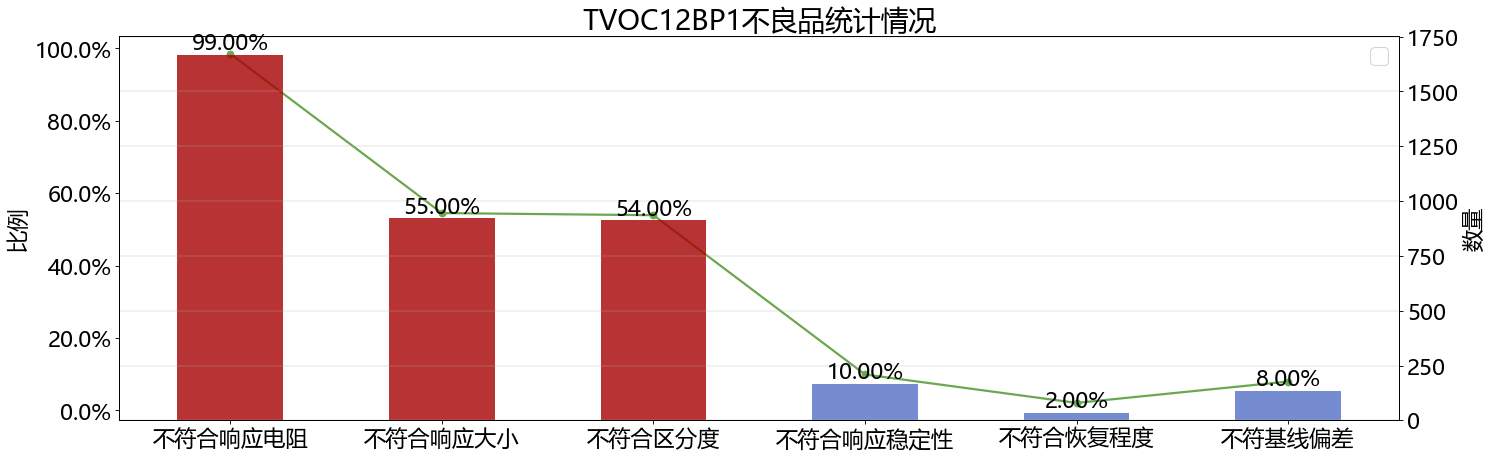

In [15]:
# sns.set()
plt.rcParams["font.size"] =20
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei'] 
fig=plt.figure(figsize=(20, 6),dpi=80)
axis_1 = fig.add_axes((0.1, 0.1, 0.8, 0.8))
plt.yticks([i for i in np.linspace(0,1,num=6)],[str(round(i,1)*100)+"%"for i in np.linspace(0, 1, num=6)])
axis_2 = axis_1.twinx()
axis_1.plot(defective_products_x, defective_products_1, color="#6AA84F", marker="o", linewidth=2)
axis_1.set_ylabel("比例", size=20) 
colors = ["#5470C6" for i in range(defective_products_x.__len__())]
colors[:3]=["#A60000" for i in range(3)]
axis_2.bar(defective_products_x,defective_products_2,width=0.5, alpha=0.8,color=colors)
axis_2.set_ylabel("数量", size=20) 

plt.grid(True, linewidth=0.3)
for i in range(defective_products_1.__len__()):  
     plt.text(defective_products_x[i], defective_products_2[i], str(round(Decimal(defective_products_1[i]),2)*100)+"%", ha='center', va= 'bottom')

plt.title(batch_name_2+"不良品统计情况", size=25)
plt.legend()
plt.savefig("不良率.png")
plt.show()


In [16]:
filtered_no=[]
for j,i in enumerate(step_6["序号"]):
        if int(i)%64 == 0:
            filtered_no.append(str(int(i)//64-1)+"+"+str(64)+"_"+str(int(step_6["部分"][j])+1)+"部分")
        else:  filtered_no.append(str(int(i)//64)+"+"+str(int(i)%64)+"_"+str(int(step_6["部分"][j])+1)+"部分")
step_6["序号"]=filtered_no

if data.columns.__len__()==10:
    filtered_no=[]
    for j,i in enumerate(step_7["序号"]):
        if int(i)%64 == 0:
            filtered_no.append(str(int(i)//64-1)+"+"+str(64)+"_"+str(int(step_7["部分"][j])+1)+"部分")
        else:  filtered_no.append(str(int(i)//64)+"+"+str(int(i)%64)+"_"+str(int(step_7["部分"][j])+1)+"部分")
    step_7["序号"]=filtered_no

In [17]:
step_6.to_excel("processed_total_TVOC.xlsx")
if data_total.columns.__len__()==10:
    step_7.to_excel("processed_total_TVOC.xlsx")

In [18]:
defective_products = []
defective_products.append(pd.merge(
    data_processed[data_processed["响应电阻"]>=3] , data_processed[data_processed["响应电阻"]<=30],how="inner"
    ).__len__()/data_processed.__len__())
defective_products.append(pd.merge(
    data_processed[data_processed["响应大小"]>=2] , data_processed[data_processed["响应大小"]<=15],how="inner"
    ).__len__()/data_processed.__len__())
defective_products.append(pd.merge(
    data_processed[data_processed["区分度"]>=1.1] , data_processed[data_processed["区分度"]<=1.5],how="inner"
    ).__len__()/data_processed.__len__())
defective_products.append(pd.merge(
    data_processed[data_processed["响应稳定性"]>=0.95] , data_processed[data_processed["响应稳定性"]<=1.05],how="inner"
    ).__len__()/data_processed.__len__())
defective_products.append(data_processed[data_processed["恢复程度"]>0.75].__len__()/data_processed.__len__())
defective_products.append(pd.merge(
    data_processed[data_processed["基线偏差"]>=-0.2] , data_processed[data_processed["基线偏差"]<=0.1],how="inner"
    ).__len__()/data_processed.__len__())
if data_total.columns.__len__()==10:
    defective_products.append(data_processed[data_processed["大浓度区分度"]>1.3].__len__()/data_processed.__len__())

In [19]:
from docx import Document 
from docx.oxml.ns import qn
from docx.enum.text import WD_ALIGN_PARAGRAPH
from docx.enum.table import WD_ALIGN_VERTICAL
from docx.shared import Cm

document =Document()
document.styles['Normal'].font.name='楷体'
document.styles['Normal']._element.rPr.rFonts.set(qn('w:eastAsia'), '楷体')
run=document.add_heading('',level=0).add_run('分析报告')
run.font.name='微软雅黑'
_title = document.styles['Title']
_title.paragraph_format.alignment = WD_ALIGN_PARAGRAPH.CENTER
paragraph = document.add_paragraph('本次测试日期为'+filepaths[0][:5]) 
paragraph.paragraph_format.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY
paragraph = document.add_paragraph('本次测试批次为：'+batch_name+'，一共测试'+str(total_num)+"个器件")

paragraph = document.add_paragraph('各参数筛选合格率') 
paragraph.paragraph_format.alignment = WD_ALIGN_PARAGRAPH.CENTER 
table = document.add_table(rows=1, cols=2, style='Table Grid') 
table.style.paragraph_format.alignment=WD_ALIGN_PARAGRAPH.CENTER
hdr_cells = table.rows[0].cells
hdr_cells[0].text = '指标名称'
hdr_cells[1].text = '值'
table.cell(0,0).width=Cm(5) 
table.cell(0,1).width=Cm(10) 

if data_total.columns.__len__()==10:
    mlst =["序号","响应电阻",
    "响应大小",
    "区分度",
    "响应稳定性",
    "恢复程度",
    "基线偏差",
    "大浓度区分度",
    ]
if data_total.columns.__len__()==9:
    mlst =["响应电阻",
    "响应大小",
    "区分度",
    "响应稳定性",
    "恢复程度",
    "基线偏差",
    ]
for i,_row in enumerate(mlst):
    row_cells = table.add_row().cells # 添一行表格元素
    row_cells[0].text = _row
    row_cells[1].text = ' '+str(round(defective_products[i],2)*100)+"%"
    p = row_cells[1].paragraphs[0]
    p.paragraph_format.alignment =WD_ALIGN_PARAGRAPH.JUSTIFY # 单元格文字两端对齐

paragraph = document.add_paragraph(' ')

paragraph = document.add_paragraph('参数筛选区间表') 
paragraph.paragraph_format.alignment = WD_ALIGN_PARAGRAPH.CENTER 
table = document.add_table(rows=1, cols=2, style='Table Grid') 
table.style.paragraph_format.alignment=WD_ALIGN_PARAGRAPH.CENTER
hdr_cells = table.rows[0].cells
hdr_cells[0].text = '指标名称'
hdr_cells[1].text = '区间范围'
table.cell(0,0).width=Cm(5) 
table.cell(0,1).width=Cm(10) 

if data_total.columns.__len__()==10:
    mlst =["序号","响应电阻",
    "响应大小",
    "区分度",
    "响应稳定性",
    "恢复程度",
    "基线偏差",
    "大浓度区分度",
    ]
    sc=["3-30K","2-15","1.1-1.5","0.95~1.05","大于0.75","-0.2~0.1","大于1.3"]
if data_total.columns.__len__()==9:
    mlst =["响应电阻",
    "响应大小",
    "区分度",
    "响应稳定性",
    "恢复程度",
    "基线偏差",
    ]
    sc=["3-30K","2-15","1.1-1.5","0.95~1.05","大于0.75","-0.2~0.1"]
for i,_row in enumerate(mlst):
    row_cells = table.add_row().cells 
    row_cells[0].text = _row
    row_cells[1].text = ' '+sc[i]
    p = row_cells[1].paragraphs[0]
    p.paragraph_format.alignment =WD_ALIGN_PARAGRAPH.JUSTIFY 

paragraph = document.add_paragraph(' ')

paragraph = document.add_paragraph('其中符合6参数器件'+str(step_6.__len__())+"个器件"+"，良品率(占测试总数量)为"+str(round(step_6.__len__()/data_total.__len__(),4)*100)+"%")
paragraph = document.add_paragraph('其中符合6参数器件:'+str(list(step_6["序号"])))

if data.columns.__len__()==10:
    paragraph = document.add_paragraph('其中符合7参数器件'+str(step_7.__len__())+"个器件"+"，良品率(占测试总数量)为"+str(round(step_7.__len__()/data_total.__len__(),4)*100)+"%")
    paragraph = document.add_paragraph('其中符合7参数器件:'+str(list(step_7["序号"])))



document.add_picture('响应电阻.png', width=Cm(15))
document.add_picture('响应大小.png', width=Cm(15))
document.add_picture('响应稳定性.png', width=Cm(15))
document.add_picture('区分度.png', width=Cm(15))
document.add_picture('恢复程度.png', width=Cm(15))
document.add_picture('基线偏差.png', width=Cm(15))

if data.columns.__len__()==10:
    document.add_picture('大浓度区分度值.png', width=Cm(15))

document.add_picture('不良率.png', width=Cm(15))

document.save('report/分析报告_'+batch_name+'.docx')
